In [1]:
#import av
import numpy as np
import math
#import trackpy
#import matplotlib #for making plots inside the notebook 
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vread
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
# take largest isodata image region, and return aclassification
def sideify(idir):
    iner = idir.inertia_tensor[0, 0] + idir.inertia_tensor[1, 1]
    maal = idir.major_axis_length
    mial = idir.minor_axis_length
    sol = idir.solidity 
    ecc = idir.eccentricity
    cva = idir.convex_area
    area = idir.area
    if area < 1280:
        return "ucf"
    elif ecc <= 0.7 and  mial > 41:
        return "t"
    elif ecc > 0.8 and ecc < 0.91 and maal > 66.5 and maal < 74: # maal > 67.5 and or (mial < 41 and maal > 65): # it's on top
        return "c"
    else:
        return "ucf"


def coord_prod(thresh_y, thresh_i):
    m_rop = measure.regionprops
    for i in range(0, 1):#len(fl):
        full = largest_region_extractor(measure.label(thresh_y))
        four = largest_region_extractor(measure.label(thresh_i))
        full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
        one_and_some = full^four
        one = largest_region_extractor(measure.label(one_and_some))
        
          
        #Begin finding substitue for major and minor axes herre
        # use min and maax x and  values to find the geometric center
        # or use those to substitue for eigenvectors 
        rotated_one = ndimage.rotate(one, math.degrees(-full_or), reshape = False)
        rotated_full = ndimage.rotate(full, math.degrees(-full_or), reshape = False)
        geo_cent = m_rop(rotated_full.astype(int), coordinates = 'rc')[0].bbox
        #print(geo_cent)
        ave = np.average
        cent_x = ave([geo_cent[1], geo_cent[3]]) 
        cent_y = ave([geo_cent[0], geo_cent[2]])
        #print(cent_x, cent_y)
        
        raw_coords = (m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords).T
        ys = raw_coords[0]
        xs = raw_coords[1]
        x = xs - cent_x
        y = ys - cent_y      
        
        one_com = m_rop(rotated_one.astype(int))[0].centroid
        
        rel_com_one = (one_com[1] - cent_x, one_com[0] - cent_y)
        product = np.prod(rel_com_one)
        return product
        
def rotate_point(point, angle):
    x0 = point[0]
    y0 = point[1]
    x1 = x0*np.cos(angle) - y0*np.sin(angle)
    y1 = x0*np.sin(angle) + y0*np.cos(angle)
    return (x1, y1)
 
def region_selector(labeled_image, label):
    #print(label)
    x = labeled_image == label
    #plt.imshow(x)
    return x

# make a function that takes a set of labeled regions, and then  returns a boolean array containing only the largest
def largest_region_extractor(labeled_regions_set):
    props_lists = measure.regionprops(labeled_regions_set)
    #print(len(labeled_regions_set), len(props_lists))
    biggest_r_p = props_lists[0]
    biggest_r_label = props_lists[0].label
    for i in range(0, len(props_lists)):
        pli = props_lists[i]
        if pli.area > biggest_r_p.area:
            biggest_r_p = pli
            biggest_r_label = pli.label
        else:
            pass
    return region_selector(labeled_regions_set, biggest_r_label)    
#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [3]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    area_threshold = 1875   # must have enough particles
    sol_threshold = 0.95
    iner_threshold = (340, 500)
    convex_thresholds = (2000, 2800)   # convex hull area (> 2500 filtered)  # particles must be in parallelogram
    minor_thresholds = (38, 48) # minor_axis length (< filterd) # particles must be in parallelogram
    #major_thresholds = (59, 76)
    major_threshold = 78
    filtrate_prop =[]
    passes = []
    otp = []
    ttp = []
    imgs = []
    for i in range(fll):
       # print("new_frame")
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_li(frame)# binary image
        img_labelled = m_lab(thresh_img) # contains connected regions
        properties_list = m_rop(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = max(properties_list, key = attrgetter('area'))
        biggest_r = m_rop(morphology.dilation(morphology.closing(m_lab(biggest_r.filled_image))), coordinates='rc')[0]
        otp.append(biggest_r)
        
        i_threshed = frame > threshold_isodata(frame)
        img2_labelled = m_lab(i_threshed)
        properties2_list = m_rop(img2_labelled, coordinates = 'rc')
        biggest_r2 = max(properties2_list, key = attrgetter('area'))
        ttp.append(biggest_r2)
        
        imgs.append((img_labelled, img2_labelled))
        #----------------------filter------------------------- can use actual filter
        test = (biggest_r.filled_area > area_threshold
               )
        if test: # keep frames that have enough paricles, and are not transitions
            if (biggest_r.inertia_tensor[0, 0] + biggest_r.inertia_tensor[1,1] > iner_threshold[0]
                and biggest_r.inertia_tensor[0, 0] + biggest_r.inertia_tensor[1,1] < iner_threshold[1]):
                #-----------------------------classify pt 1---------------------------------------
                coprod = coord_prod(thresh_img, i_threshed)
                side = sideify(biggest_r2)
                clas = side #classify(side, -coprod)
                filtrate_prop.append((biggest_r, biggest_r2))
            else:
                clas = 'ucf'
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(biggest_r)
            
    return [filtrate_prop, passes, otp, ttp, imgs]






In [4]:
"Retreving properties for test frames with 1st hreshold"
"USING LI THRESHOLD"
# applies yen filter to test frames, and gets properties
# returns list of the properties
#  fraemelist is a frame and a frame index
def opaque_threshold_properties(framelist, indes):
    filtrate = []
    for i in range(len(framelist)):
        frame = framelist[i]
        thresh_img = frame > threshold_li(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = properties_list[0] 
        
        for region in properties_list:
            if region.area > biggest_r.area:
                biggest_r = region
            else:
                pass
        
        biggest_r = measure.regionprops(morphology.dilation(morphology.closing(measure.label(biggest_r.filled_image))), coordinates='rc')[0]  
        filtrate.append(biggest_r)#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate

In [5]:
"Retreving properties for test frames with 2nd threshold"

# applies isodata filter to test frames, and gets properties
# returns list of the properties
def transparent_threshold_properties(framelist, indes):
    filtrate = []
    for i in range(len(framelist)):
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r_p = properties_list[0] 
        
        for region_props in properties_list:
            region = img_labelled
            if region_props.area > biggest_r_p.area:
                biggest_r_p = region_props
            else:
                pass
            
        filtrate.append(biggest_r_p)#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate


In [6]:
filenames = filename = glob("./tchakamau/2ND*/test*[1-4].avi")#glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 4
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames = {"t" : list(range(58515, 58250, -1)),
                  "c" :list(range(61868, 59044, -20)), 
                 "broken" :list(range(58914, 58780, -1)) ,
                 "odd_s" :list(range(58776, 58722, -1)) }
phantom_frames_2 = {"t" : list(range(19523, 19497, -1)),
                  "c" :list(range(19258,18877, -1 )), 
                 "broken" :list(range(19377, 19311, -1)) ,
                 "odd_s" :list(chain(range(19794, 19657, -2), range(19621, 19586, -1), range(19433, 19396, -1))) }
phantom_frames_3 = {"t" :list(range(37582, 37184, -1)),
                  "c" :list(range(38638, 38456, -1)), 
                 "broken" :list(range(37892, 37593, -1)) ,
                 "odd_s" :list(range(39748, 37894, -3)) }
phantom_frames_4 = {"t" :list(range(25494, 25293, -1)),
                  "c" :list(range(27133, 26587, -1)), 
                 "broken" :list(range(21468, 21037, -1)) ,
                 "odd_s" :list(range(21869, 21836, -1)) }
"""phantom_frames = {"t" : list(range(13268, 13529)),
                  "c" :list(range(16740, 16951)), 
                 "broken" :list(range(14224, 14623, 2)) ,
                 "odd_s" :list(range(14001,14044)) }
phantom_frames_2 = {"t" : list(range(21985, 22175)),
                  "c" :list(range(18192, 18400)), 
                 "broken" :list(range(20904, 21625, 4)) ,
                 "odd_s" :list(chain(range(20360, 20381), range(20386, 20420))) }
phantom_frames_3 = {"t" :list(range(3266, 3491)),
                  "c" :list(range(3574, 3597)), 
                 "broken" :list(range(3686, 4209, 3)) ,
                 "odd_s" :list(chain(range(3521, 3538), range(3668, 3680))) }
phantom_frames_4 = {"t" :list(range(9361, 9709, 2)),
                  "c" :list(range(12800,13578, 3)), 
                 "broken" :list(range(11057, 11482, 2)) ,
                 "odd_s" :[] }"""
phantom_frame_sets = [phantom_frames,phantom_frames_2,phantom_frames_3, phantom_frames_4]
trigger_frames = [61868, 19794, 38638, 27133]#[13268, 18192, 2964, 8535]


['./tchakamau\\2ND_4_PRTS\\test_1.avi', './tchakamau\\2ND_4_PRTS\\test_2.avi', './tchakamau\\2ND_4_PRTS\\test_3.avi', './tchakamau\\2ND_4_PRTS\\test_4.avi']


In [7]:
t_frames = []
tvals  = []
c_frames = []
cvals = []

odd_s_frames = []
oddsvals = []
broken_frames = []
brokenvals = []


framesets = [t_frames, c_frames,  odd_s_frames, 
             broken_frames]
frametypevals = [tvals, cvals,  oddsvals, brokenvals]
framesetnames = ["t", "c", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []
    
for vidnum in range(len(filenames)):
    frames = vread(filenames[vidnum])
    frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(len(frame_vid))
    
    
    for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        frametypevals[i].extend(typevals)
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])


6619
6069
2556
6471


In [8]:
filtrates_props = []
passes = []
i_props = []
t_props = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(frametypevals[i])
    fil = len(x[1])
    print(orig, len(filtrates_props[i]), len(x[1]))
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", fil*100/orig)
        passes.append(fil*100/orig)
    print("\n")
        

    i_props.append(x[2])
    t_props.append(x[3])
    limgs.append(x[4])
Pass_ratios = passes
Filtrates_props = filtrates_props
I_thresh_props = i_props
T_thresh_props = t_props
st = framesets
np.save('shape_testing.npy',st)
print(len(i_props), len(t_props), len(filtrates_props))

890 886 879
t _vid
original_vid:  890
filtrate:  879
pass ratio:  98.76404494382022


1251 1226 1217
c _vid
original_vid:  1251
filtrate:  1217
pass ratio:  97.28217426059153


846 784 147
odd_s _vid
original_vid:  846
filtrate:  147
pass ratio:  17.375886524822697


930 39 917
broken _vid
original_vid:  930
filtrate:  917
pass ratio:  98.60215053763442


4 4 4


Area averages: 
t : ave - 2118 var - 279 % 
c : ave - 2172 var - 292 % 
odd_s : ave - 2100 var - 657 % 
broken : ave - 1595 var - 2523 % 
Area averages: 
t : ave - 2119 var - 276 % 
c : ave - 2175 var - 297 % 
odd_s : ave - 2105 var - 632 % 
broken : ave - 1597 var - 2490 % 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


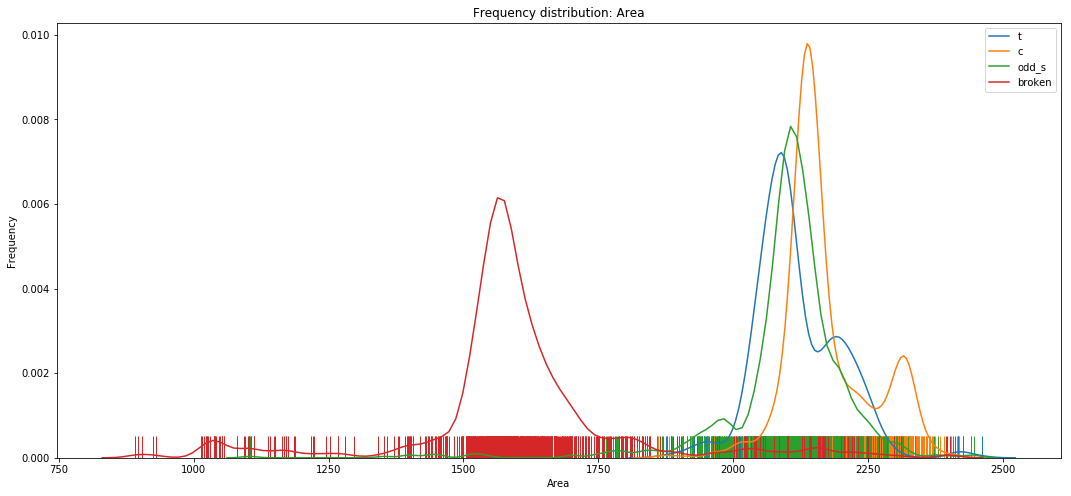

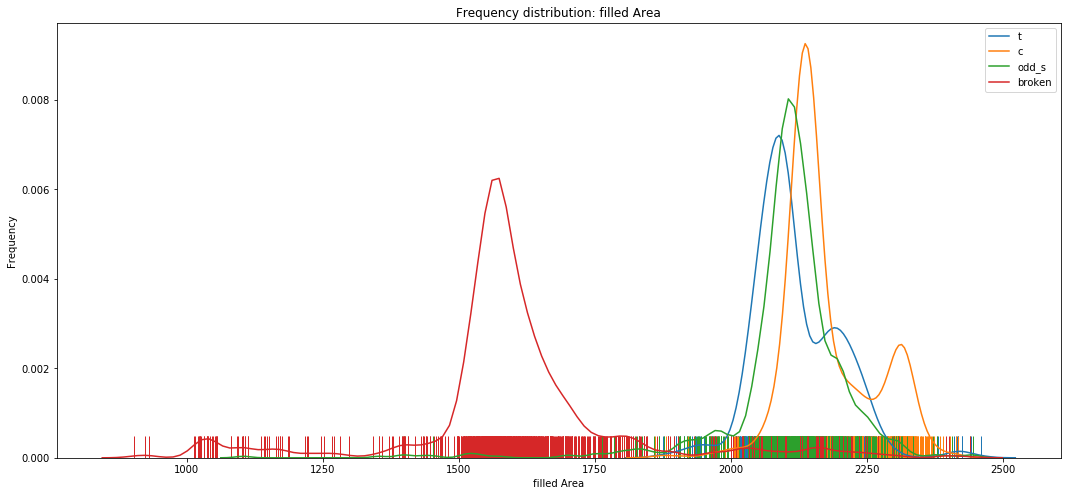

In [9]:
"""Determining the correct area threshold"""
# use area information from properties
Areas_list = []
for i in range(num_shape_cats):
    x = [h.area for h in I_thresh_props[i]]
    Areas_list.append(x) #list of areas for every category
print("Area averages: ")
[print("%s : ave - %.f var - %.f %% " %(framesetnames[i], np.average(Areas_list[i]),
                                       np.var(Areas_list[i]) *100/ np.average(Areas_list[i])
                                       )) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
#plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: Area")
plt.xlabel("Area")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Areas_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
    
    
"""Determining the correct area threshold"""
# use area information from properties
Areas_list = []
for i in range(num_shape_cats):
    x = [h.filled_area for h in I_thresh_props[i]]
    Areas_list.append(x) #list of areas for every category
print("Area averages: ")
[print("%s : ave - %.f var - %.f %% " %(framesetnames[i], np.average(Areas_list[i]),
                                       np.var(Areas_list[i]) *100/ np.average(Areas_list[i])
                                       )) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
#plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: filled Area")
plt.xlabel("filled Area")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Areas_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

Inertia averages: 
t : 378 
c : 414 
odd_s : 398 
broken : 311 
Inertia variances: 
t : 359 
c : 1246 
odd_s : 2135 
broken : 5549 
Len_difs_list averages: 
t : -5 
c : -6 
odd_s : -5 
broken : -6 
Len_difs_list variances: 
t : 13 
c : 29 
odd_s : 23 
broken : 36 
ecc_difs_list averages: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
ecc_difs_list variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
convex_area averages: 
t : 2341 
c : 2421 
odd_s : 2362 
broken : 1791 
convex_area variances: 
t : 12514 
c : 21277 
odd_s : 31997 
broken : 73288 
minor_axis_length averages: 
t : 45 
c : 42 
odd_s : 44 
broken : 41 
minor_axis_length variances: 
t : 2 
c : 1 
odd_s : 4 
broken : 36 
major_axis_length averages: 
t : 63 
c : 69 
odd_s : 67 
broken : 56 
major_axis_length variances: 
t : 5 
c : 18 
odd_s : 30 
broken : 122 
solidity averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
solidity variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
eccentricity averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
eccent

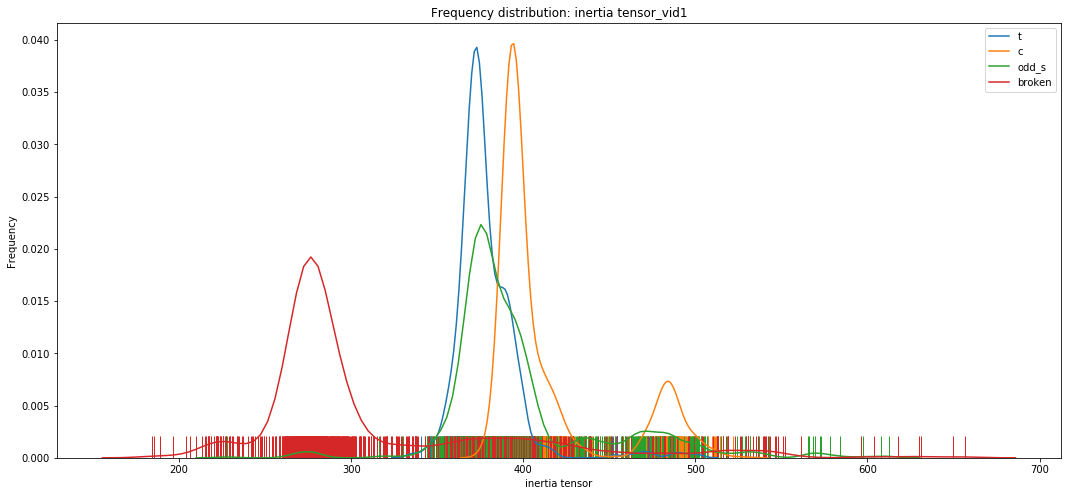

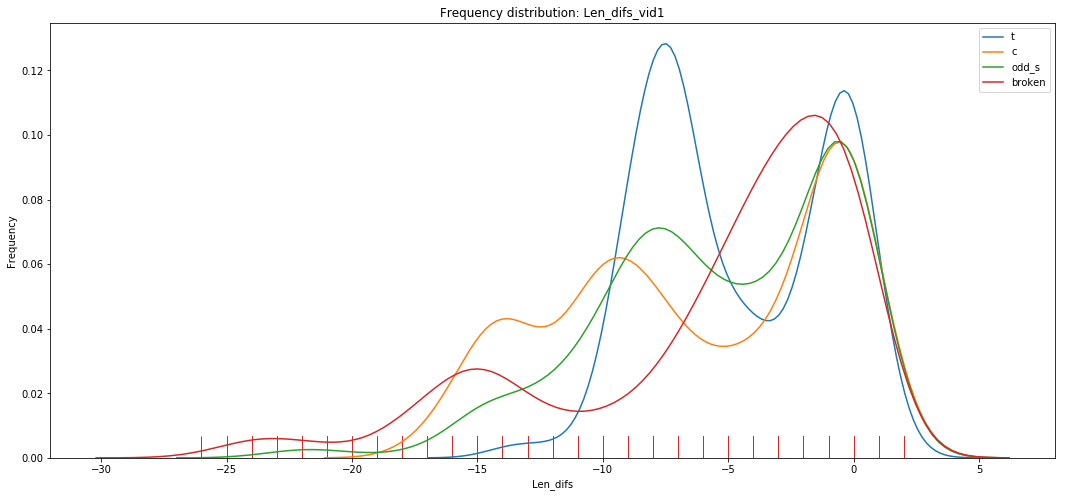

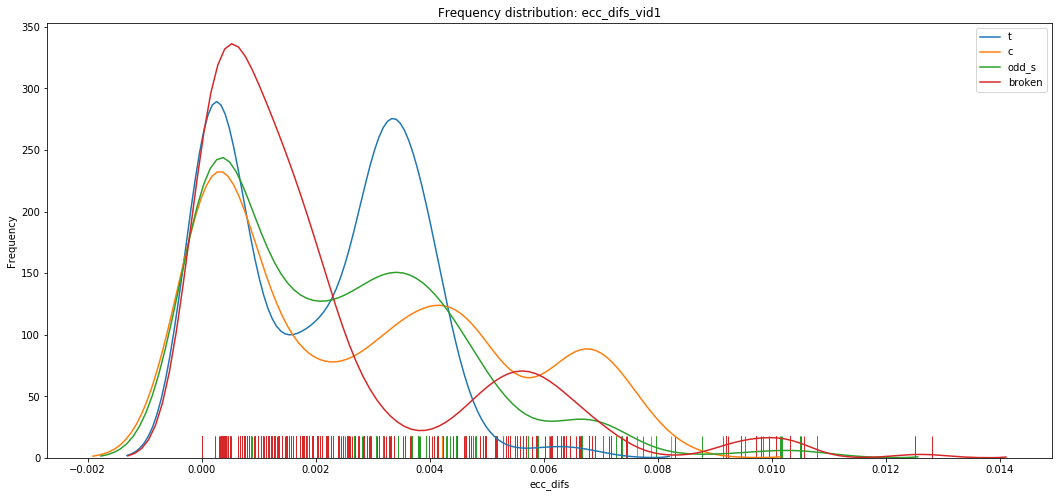

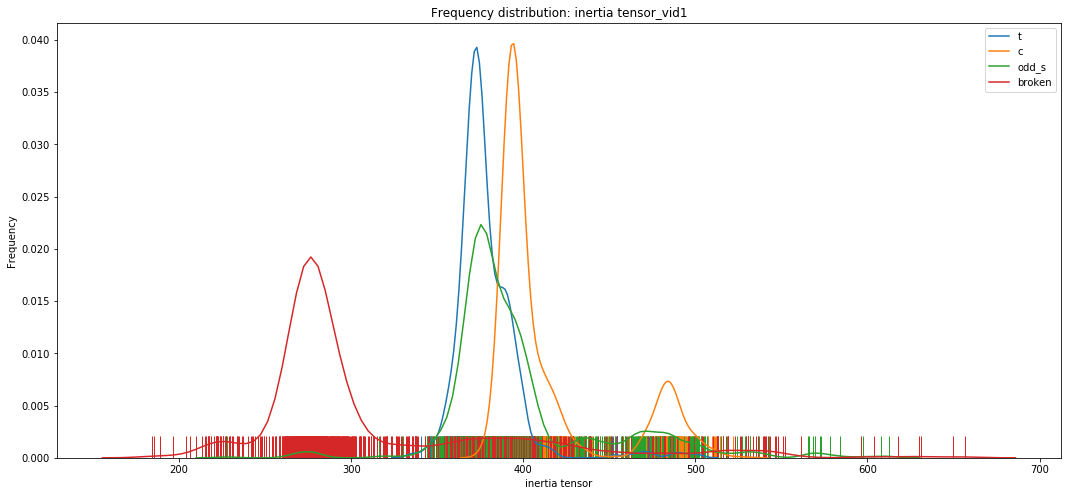

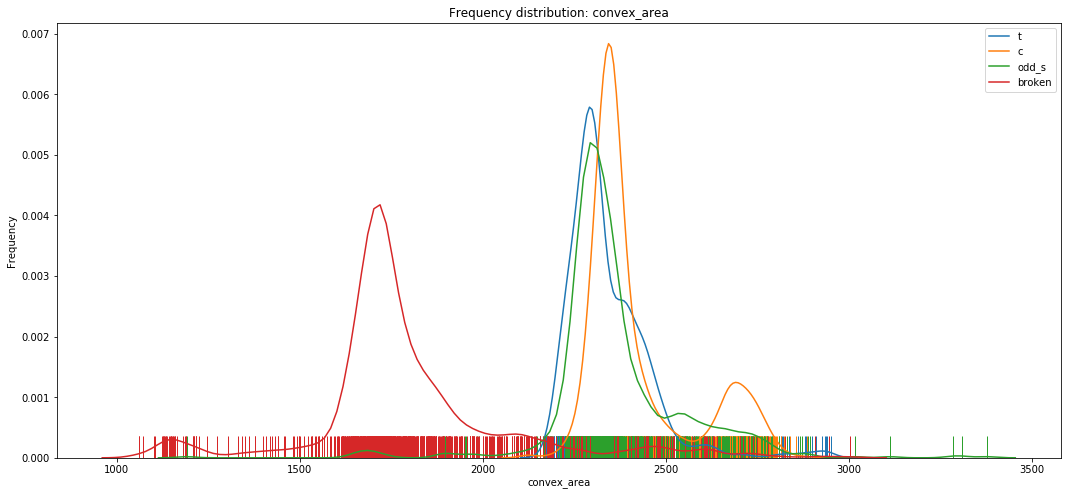

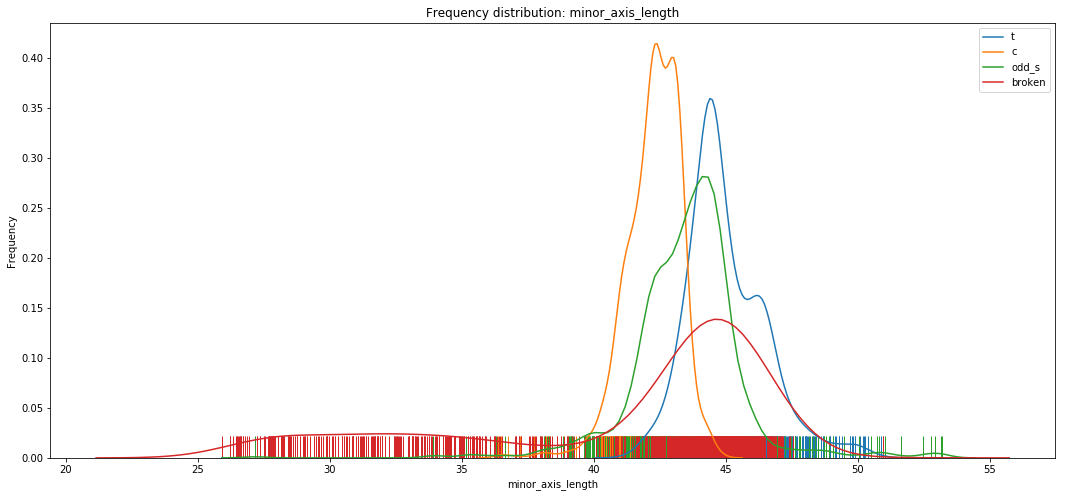

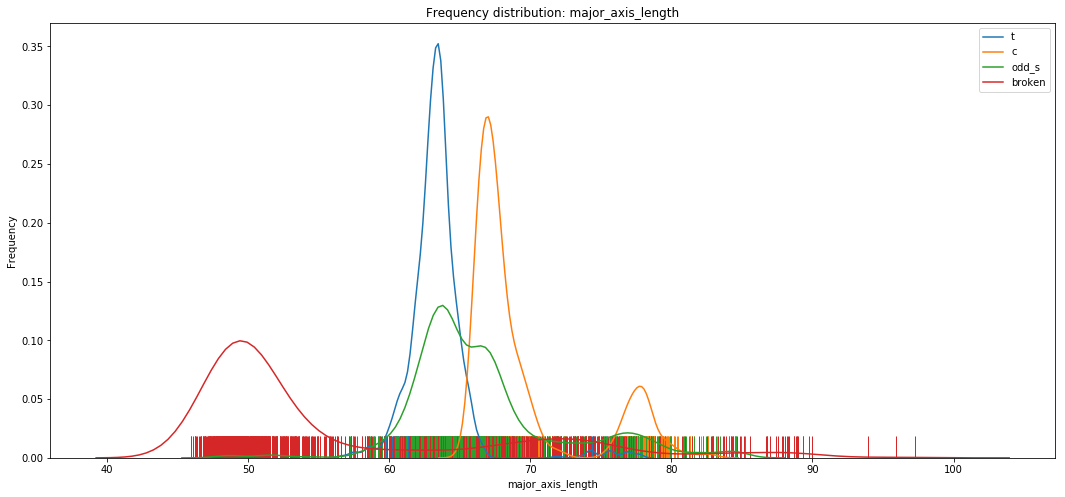

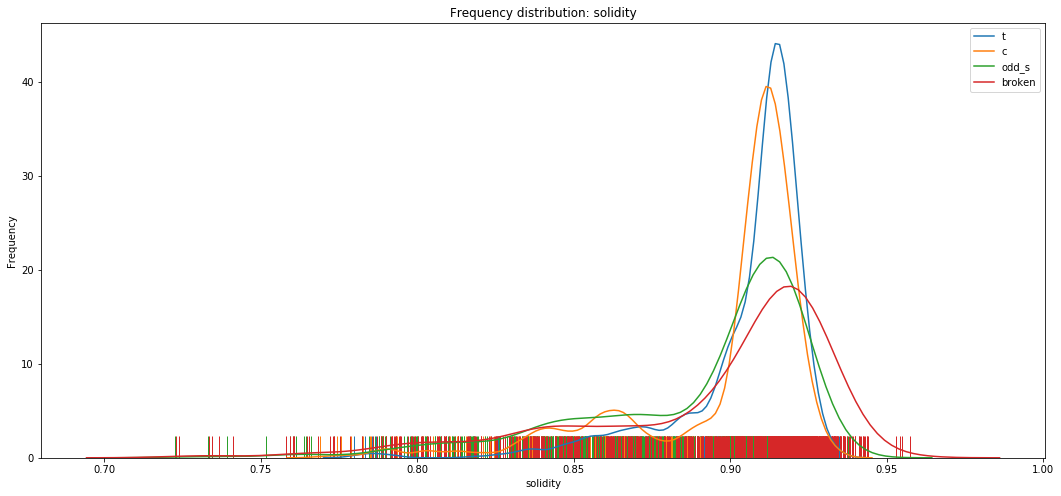

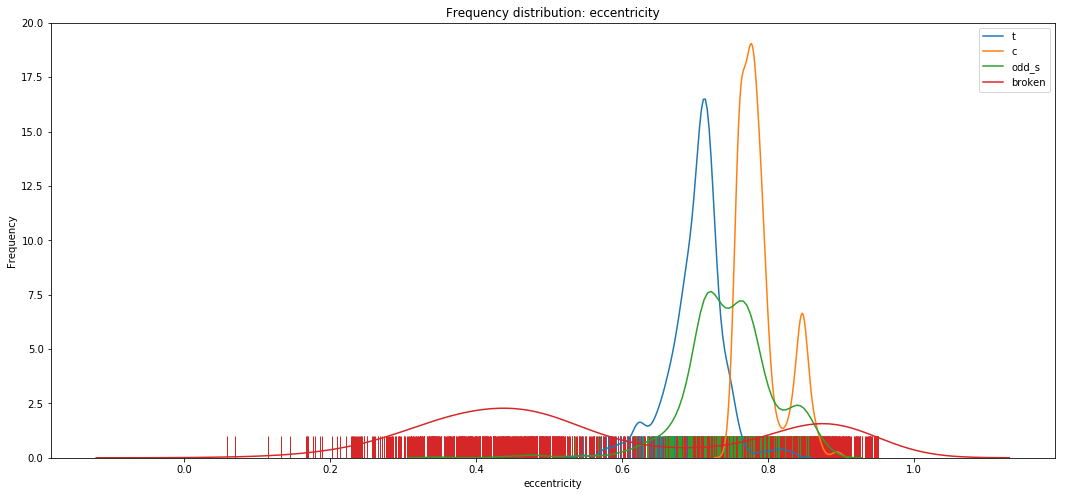

In [10]:
"""FINDING CORRECT THRESHOLDS FOR SEPARATING BROKEN AND ODD SHAPED FRAMES"""

# use area information from properties
Inertias_list = []
for i in range(num_shape_cats):
    x = [h.inertia_tensor[0, 0] + h.inertia_tensor[1,1] for h in I_thresh_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid1")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
#--------

#------------------------

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid1")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

propnames = ["convex_area", "minor_axis_length", "major_axis_length", "solidity", "eccentricity"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h, propnames[k]) for h in I_thresh_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

t : ave - 2118 var - 266 % 
c : ave - 2171 var - 280 % 
odd_s : ave - 2111 var - 235 % 
broken : ave - 2124 var - 955 % 


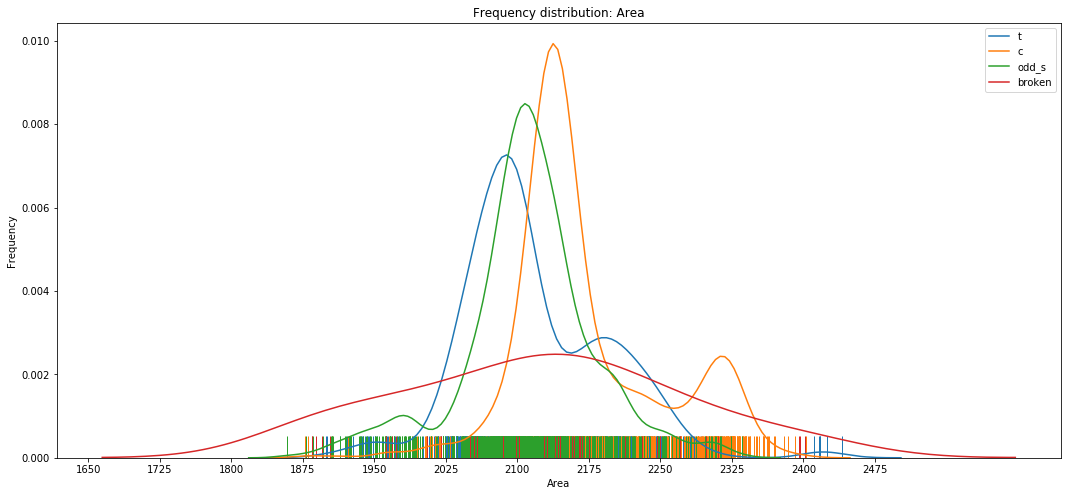

In [11]:
"""PTINTING RESULTS OF FILTERING"""
# use area information from properties
Areas_list = []
for i in range(num_shape_cats):
    x = [h[0].area for h in Filtrates_props[i]]
    Areas_list.append(x) #list of areas for every category
#print("Area averages: ")
[print("%s : ave - %.f var - %.f %% " %(framesetnames[i], np.average(Areas_list[i]),
                                   np.var(Areas_list[i])*100/ np.average(Areas_list[i])
                                  )) for i in range(num_shape_cats)]
fig, ax = plt.subplots(figsize=(18,8))
plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: Area")
plt.xlabel("Area")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Areas_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
   


Inertia averages: 
t : 378 
c : 412 
odd_s : 394 
broken : 440 
Inertia variances: 
t : 337 
c : 1093 
odd_s : 1127 
broken : 1139 
convex_area averages: 
t : 2341 
c : 2416 
odd_s : 2360 
broken : 2452 
convex_area variances: 
t : 12083 
c : 19943 
odd_s : 14621 
broken : 22348 
minor_axis_length averages: 
t : 45 
c : 42 
odd_s : 44 
broken : 43 
minor_axis_length variances: 
t : 2 
c : 1 
odd_s : 3 
broken : 8 
major_axis_length averages: 
t : 63 
c : 69 
odd_s : 66 
broken : 72 
major_axis_length variances: 
t : 5 
c : 15 
odd_s : 19 
broken : 20 
solidity averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
solidity variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 


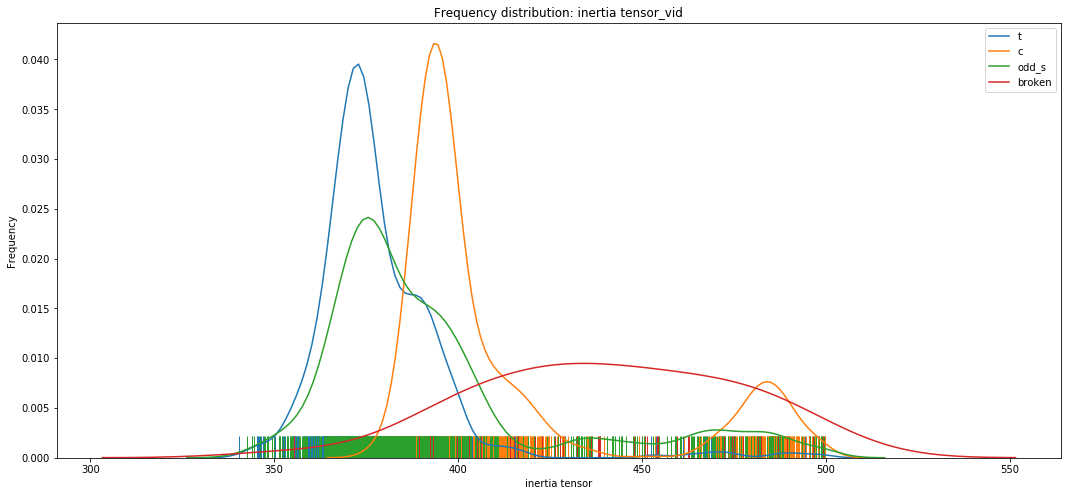

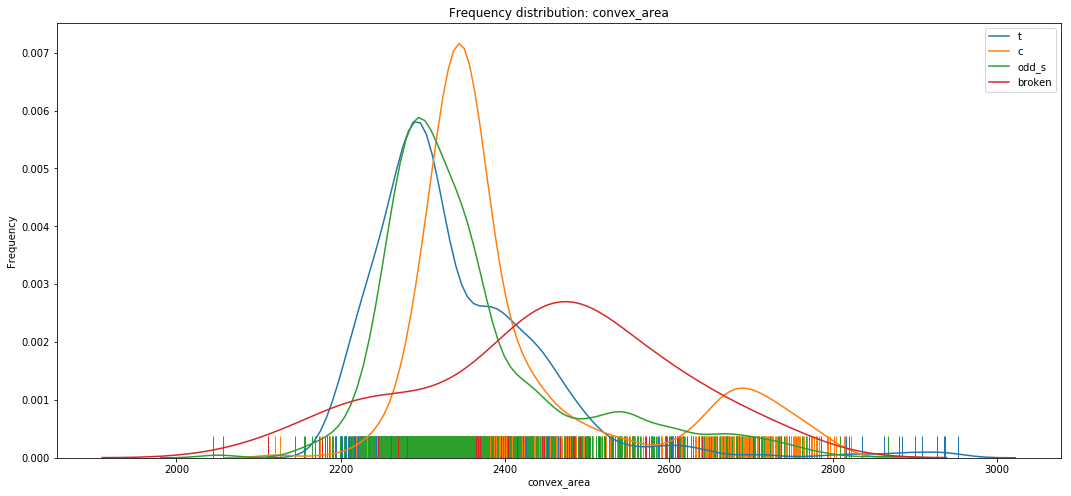

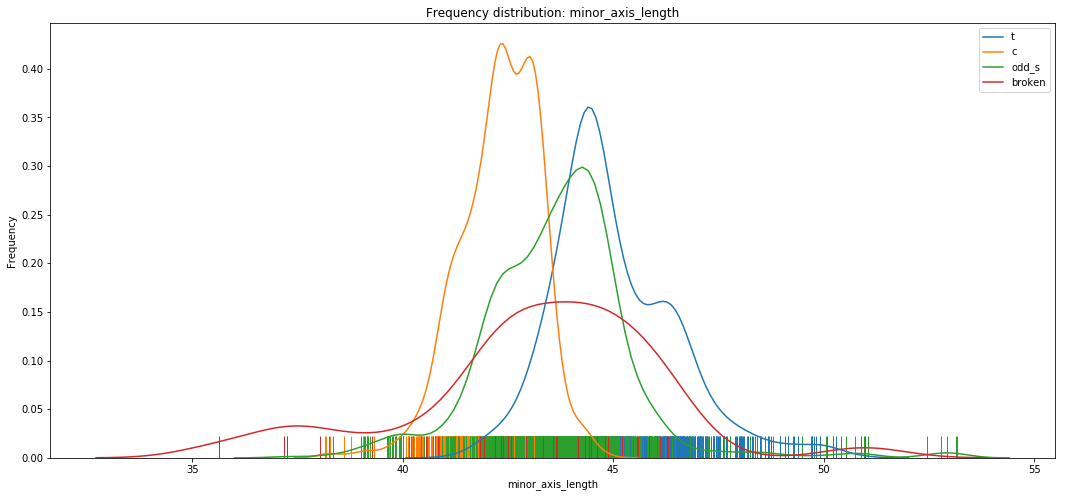

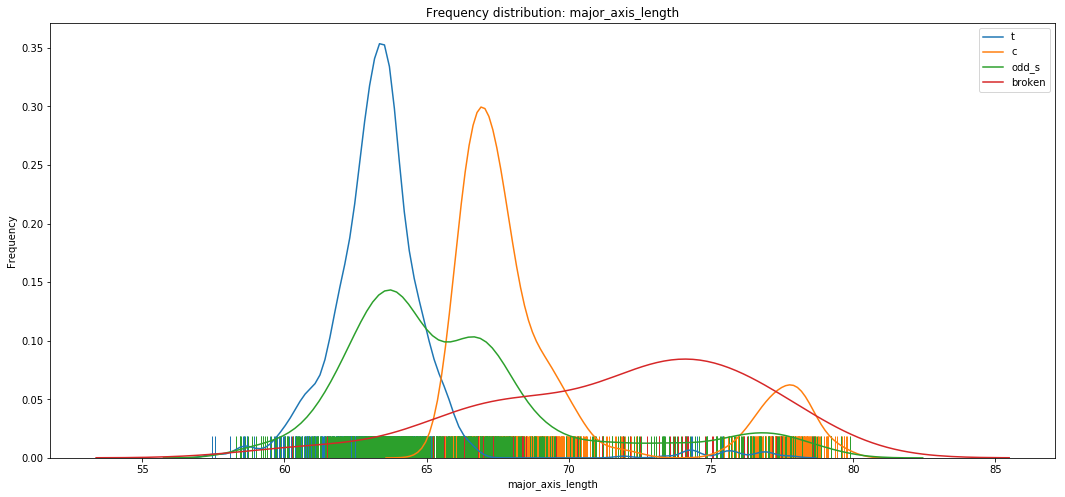

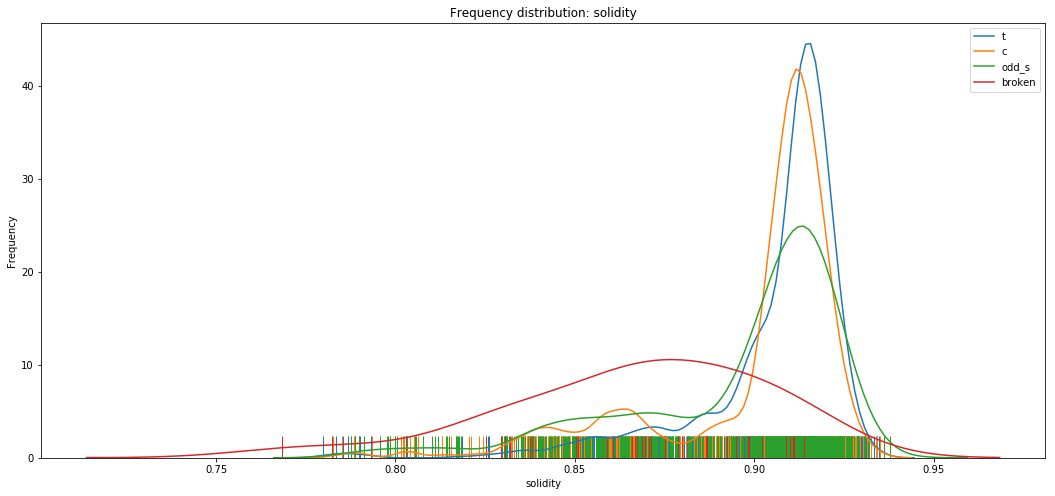

In [12]:
"""STILL RESULTS OF FILTERING"""
Inertias_list = []
for i in range(num_shape_cats):
    x = [h[0].inertia_tensor[0, 0] + h[0].inertia_tensor[1,1] for h in Filtrates_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

propnames = ["convex_area", "minor_axis_length", "major_axis_length", "solidity"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h[0], propnames[k]) for h in Filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])


In [13]:
"""Pt3. Separating variosu shapes
"""

'Pt3. Separating variosu shapes\n'

In [14]:
"SEE HOW THE ISODATA FILTER TREATS FRAMES - UNFILTERED"                               

'SEE HOW THE ISODATA FILTER TREATS FRAMES - UNFILTERED'

len_diff averages: 
t : 4 
c : 5 
odd_s : 9 
broken : 19 
len_diff variances: 
t : 9 
c : 15 
odd_s : 179 
broken : 192 


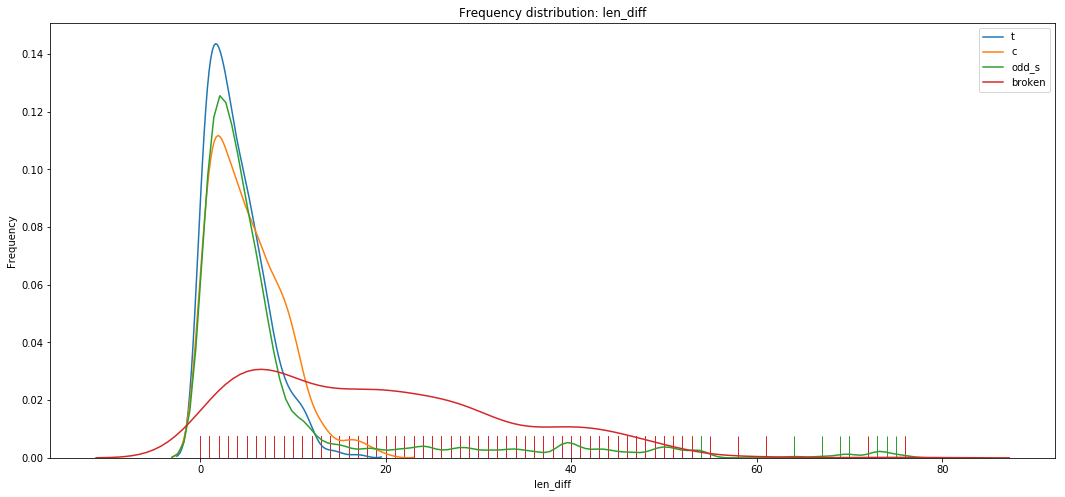

In [21]:
"""COMPARING A MEASIREMENT ACROSS THRESHOLDS"""
propnames = ["len_diff"]
for k in range(0, len(propnames)):
    klist = []
    for x in range(num_shape_cats):
        ldiffs = []
        for limg_pair in limgs[x]:
            full = largest_region_extractor(limg_pair[0])
            four = largest_region_extractor(limg_pair[1])
            full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
            one_and_some = full^four
            one = largest_region_extractor(measure.label(one_and_some))
            rotated_one = ndimage.rotate(one, math.degrees(-full_or), reshape = False)
            rotated_full = ndimage.rotate(full, math.degrees(-full_or), reshape = False)
            geo_cent = m_rop(rotated_full.astype(int), coordinates = 'rc')[0].centroid#m_rop(rotated_full.astype(int), coordinates = 'rc')[0].bbox
            #print(geo_cent)

            cent_x = int(geo_cent[1])#int(ave([geo_cent[1], geo_cent[3]]) )
            cent_y = int(geo_cent[0])#int(ave([geo_cent[0], geo_cent[2]]))
            #print(cent_x, cent_y)

            one_com = m_rop(rotated_one.astype(int))[0].centroid

            rel_com_one = (one_com[1] - cent_x, one_com[0] - cent_y) # vector of com of the dot relative to geometric center
            #print("com of dot relative geo_cent", rel_com_one, np.prod(rel_com_one))
            

            raw_coords = (m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords).T
            ys = raw_coords[0]
            xs = raw_coords[1]
            thresh_for_middle = [ys[i] for i in range(len(ys)) if xs[i] == max(xs) ][0]
            xt =[(xs - cent_x)[i] for i in range(len(xs - cent_x)) if ys[i] > thresh_for_middle] 
            yt = [(ys - cent_y)[i] for i in range(len(ys-cent_y)) if ys[i] > thresh_for_middle] 
            xb =[(xs - cent_x)[i] for i in range(len(xs - cent_x)) if ys[i] <= thresh_for_middle] 
            yb = [(ys - cent_y)[i] for i in range(len(ys-cent_y)) if ys[i] <= thresh_for_middle] 
            top = np.zeros((256, 256))
            tbase = np.asarray([yt, xt])
            top[tbase[0]+cent_y, tbase[1]+cent_x] = 1
            bottom = np.zeros((256, 256)) 
            bbase = np.asarray([yb, xb])
            bottom[bbase[0]+cent_y, bbase[1]+cent_x] = 1
            #ecc_dif = max(m_rop(measure.label(morphology.dilation(top)), coordinates = 'rc'), key = attrgetter('area')).eccentricity - max(m_rop(measure.label(morphology.dilation(bottom)), coordinates = 'rc'), key = attrgetter('area')).eccentricity            
            tlength = abs(max(m_rop(measure.label(morphology.dilation(top)), coordinates = 'rc'), key = attrgetter('area')).bbox[0]) - abs(max(m_rop(measure.label(morphology.dilation(top)), coordinates = 'rc'), key = attrgetter('area')).bbox[2] )
            blength = abs(max(m_rop(measure.label(morphology.dilation(bottom)), coordinates = 'rc'), key = attrgetter('area')).bbox[0])- abs(max(m_rop(measure.label(morphology.dilation(bottom)), coordinates = 'rc'), key = attrgetter('area')).bbox[2]  )
            len_dif = abs(tlength-blength)
            ldiffs.append(len_dif)
        klist.append(ldiffs) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        

# most oddly shaped frames have elongated shapes, and the mnor axis length is below 40, except for one (of one partcular type)
# where the pixels for a 'T' shape; this, while more rounded, has a huge convex hull. All frames wth convex hull area 
# over 2500 (very conservatve estimate) areoddly shaped (transition frames). 
# Together the criteria select for frames not in transition.
#16766 is misclassified, but it isvery like a normally shaped t_l on most measures, so maybe it should be counted as one for this program

area averages: 
t : 1489 
c : 1488 
odd_s : 1451 
broken : 1334 
area variances: 
t : 5273 
c : 6429 
odd_s : 9141 
broken : 68896 
extent averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
extent variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 


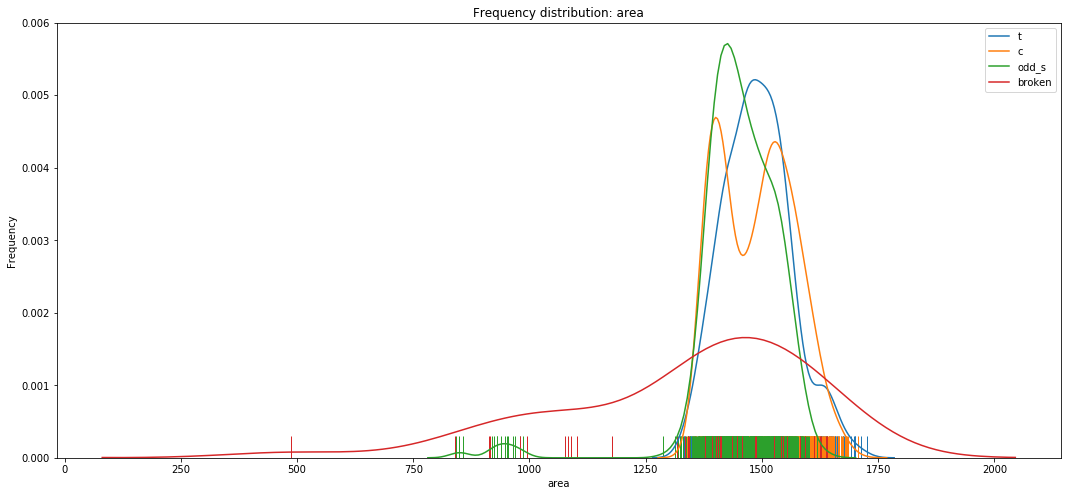

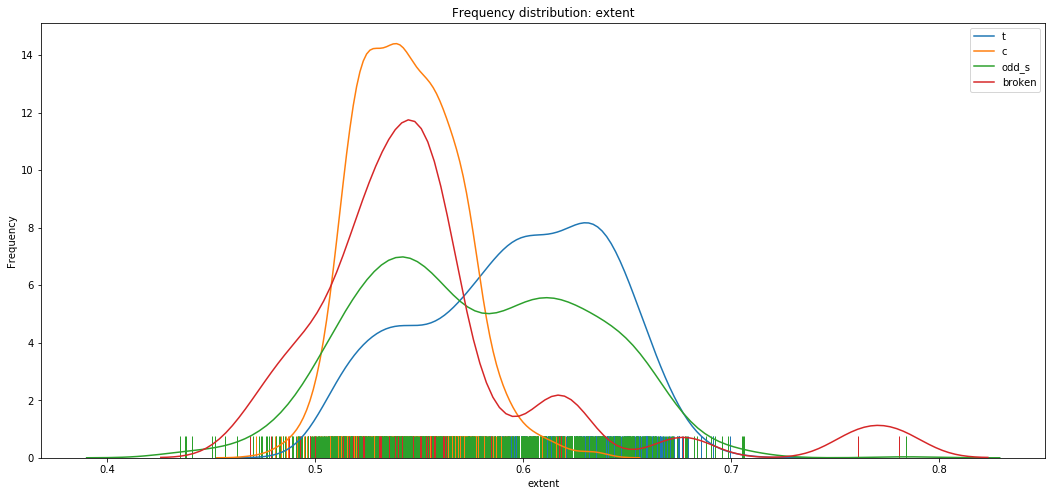

In [22]:
"""PTINTING RESULTS OF FILTERING - ISODATA THRESHOLDS"""
propnames = ["area", "extent"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h[1], propnames[k]) for h in Filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        

# most oddly shaped frames have elongated shapes, and the mnor axis length is below 40, except for one (of one partcular type)
# where the pixels for a 'T' shape; this, while more rounded, has a huge convex hull. All frames wth convex hull area 
# over 2500 (very conservatve estimate) areoddly shaped (transition frames). 
# Together the criteria select for frames not in transition.
#16766 is misclassified, but it isvery like a normally shaped t_l on most measures, so maybe it should be counted as one for this program

Inertia averages: 
t : 283 
c : 389 
odd_s : 326 
broken : 212 
Inertia variances: 
t : 367 
c : 103 
odd_s : 4195 
broken : 3305 
Inertia averages: 
t : 283 
c : 388 
odd_s : 323 
broken : 333 
Inertia variances: 
t : 366 
c : 100 
odd_s : 3387 
broken : 8489 
convex_area averages: 
t : 1827 
c : 1938 
odd_s : 1814 
broken : 1186 
convex_area variances: 
t : 26291 
c : 14486 
odd_s : 48745 
broken : 83218 
convex_area averages: 
t : 1827 
c : 1940 
odd_s : 1819 
broken : 1742 
convex_area variances: 
t : 26257 
c : 14358 
odd_s : 36299 
broken : 163269 
minor_axis_length averages: 
t : 44 
c : 35 
odd_s : 39 
broken : 28 
minor_axis_length variances: 
t : 2 
c : 3 
odd_s : 32 
broken : 16 
minor_axis_length averages: 
t : 44 
c : 35 
odd_s : 39 
broken : 33 
minor_axis_length variances: 
t : 2 
c : 3 
odd_s : 28 
broken : 47 
major_axis_length averages: 
t : 51 
c : 71 
odd_s : 60 
broken : 50 
major_axis_length variances: 
t : 9 
c : 3 
odd_s : 115 
broken : 80 
major_axis_length ave

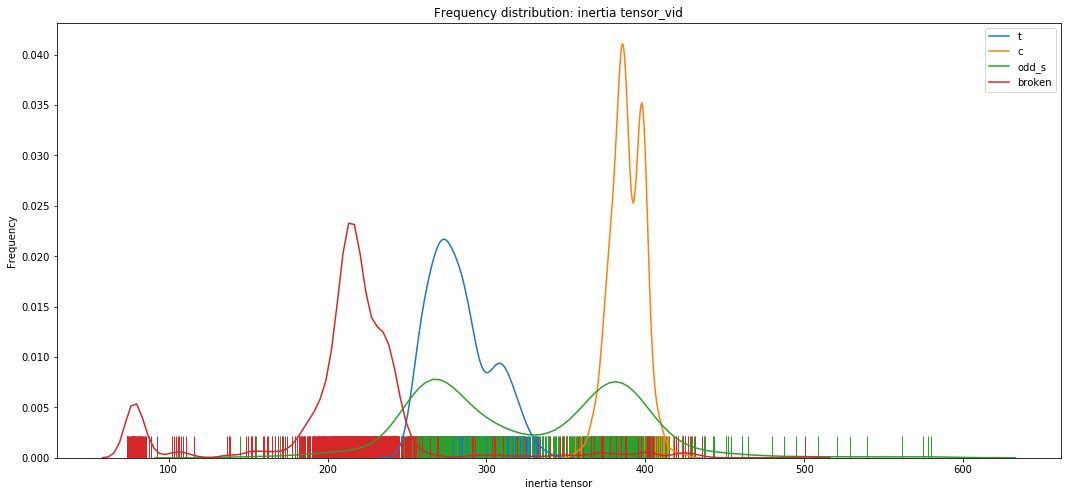

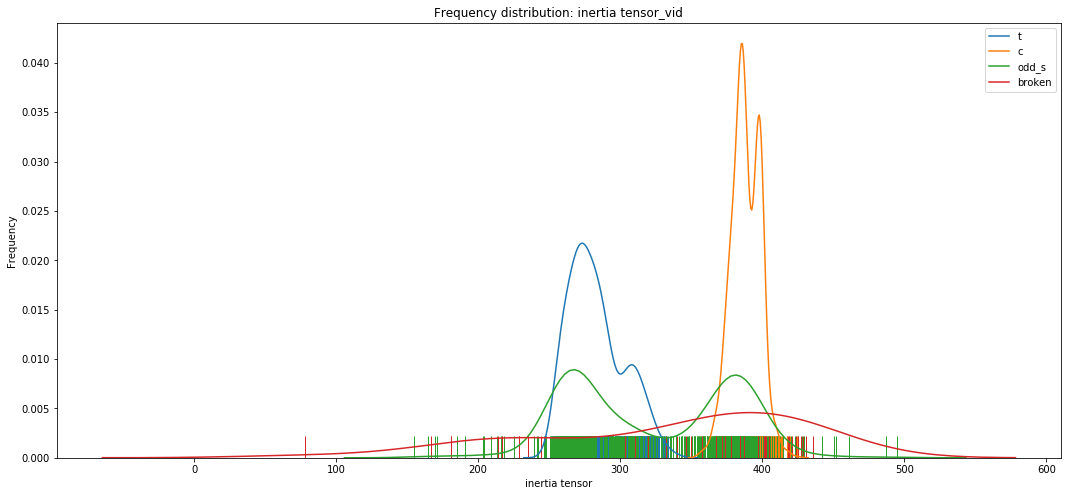

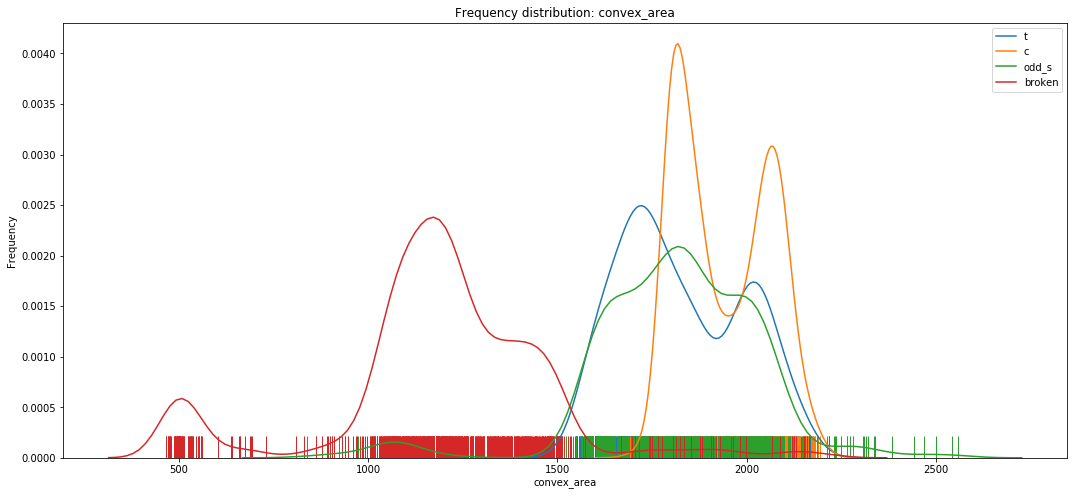

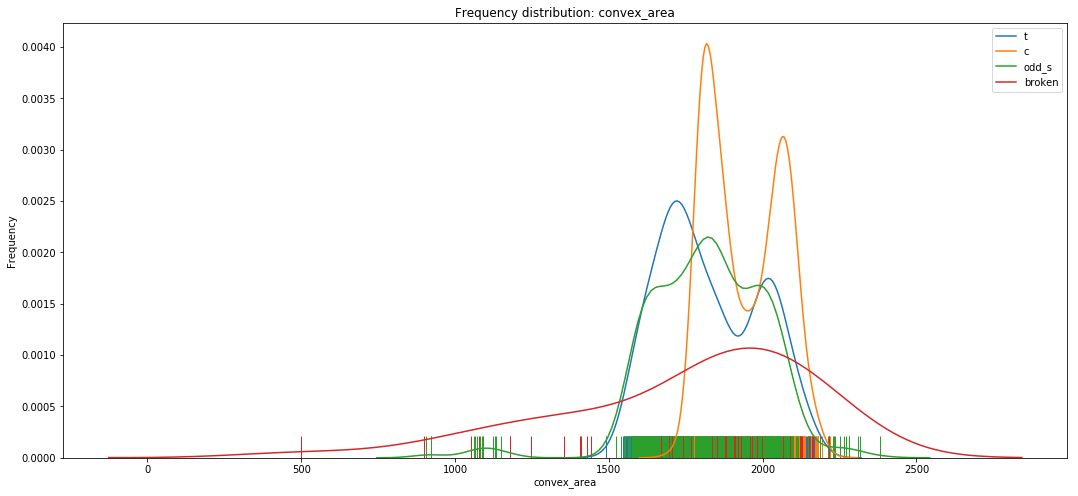

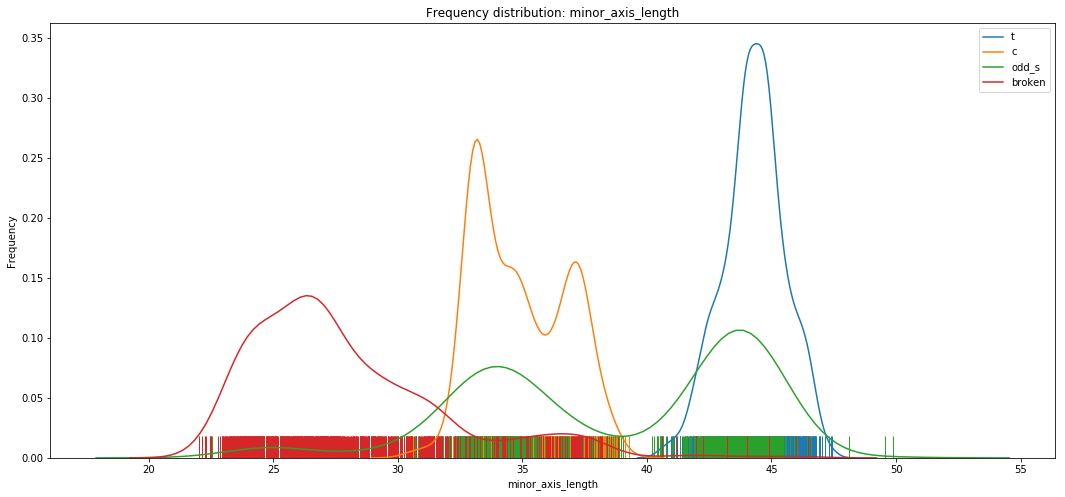

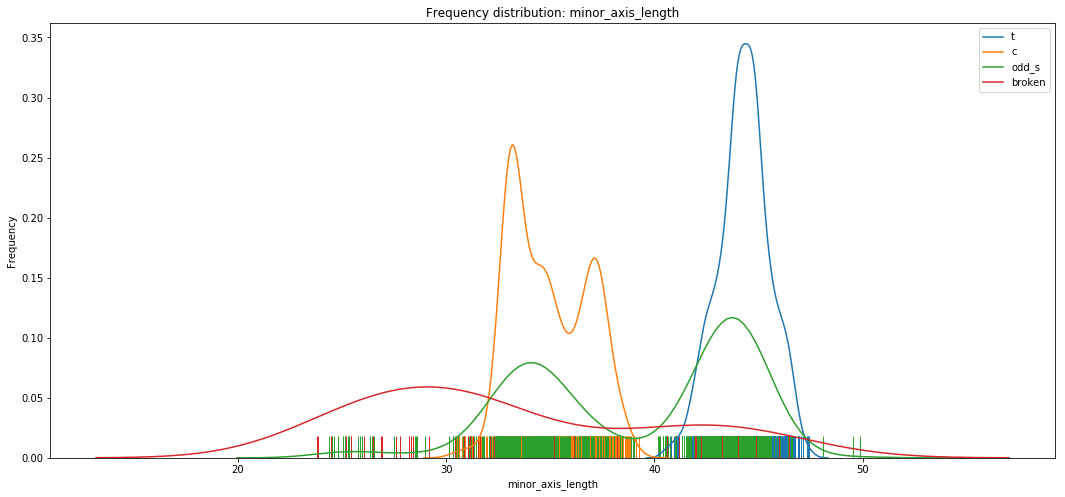

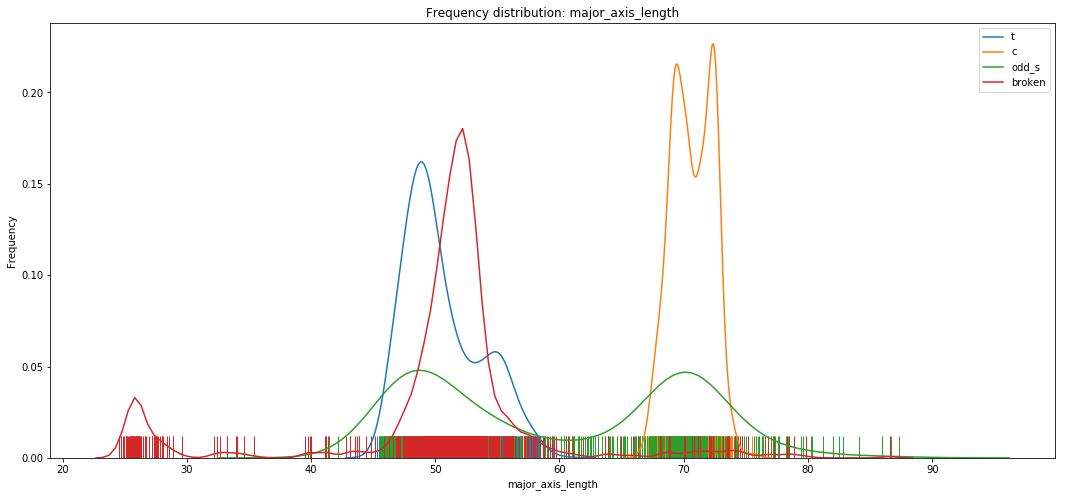

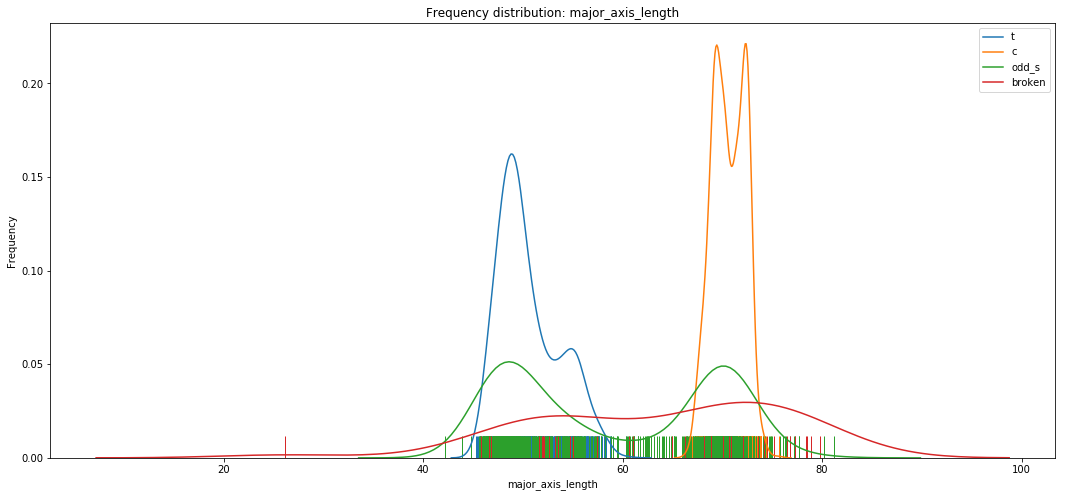

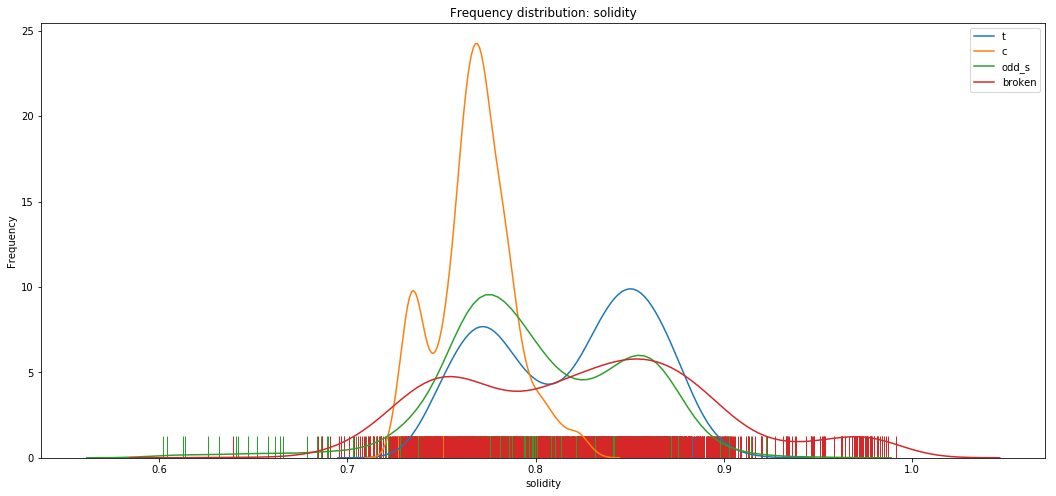

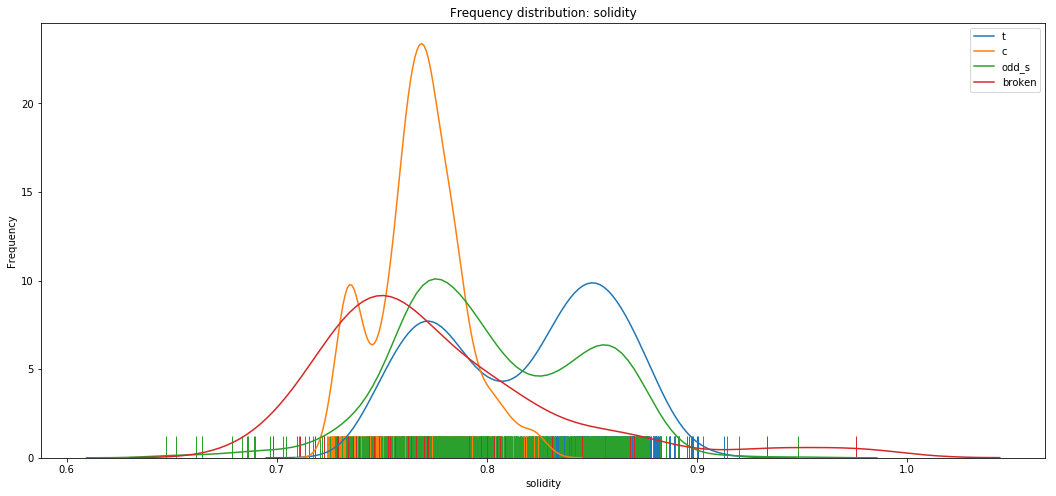

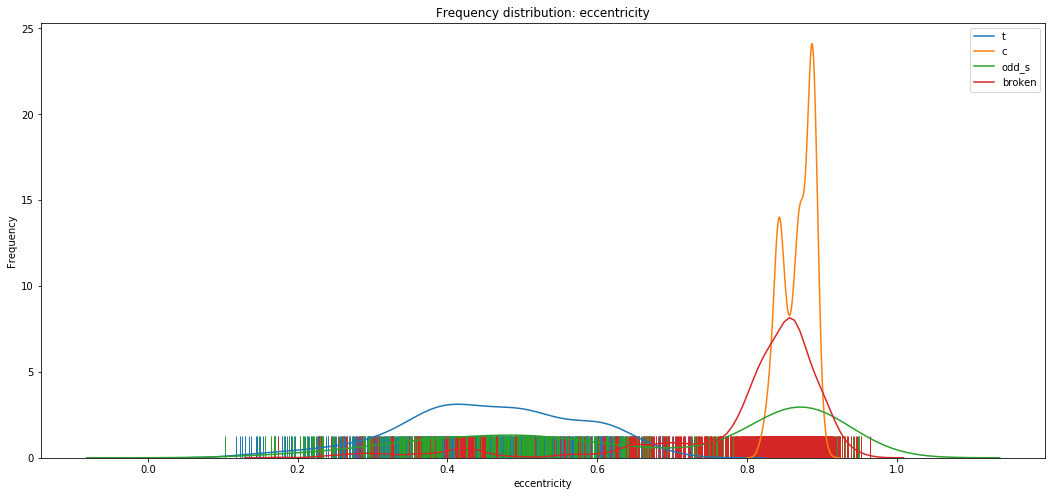

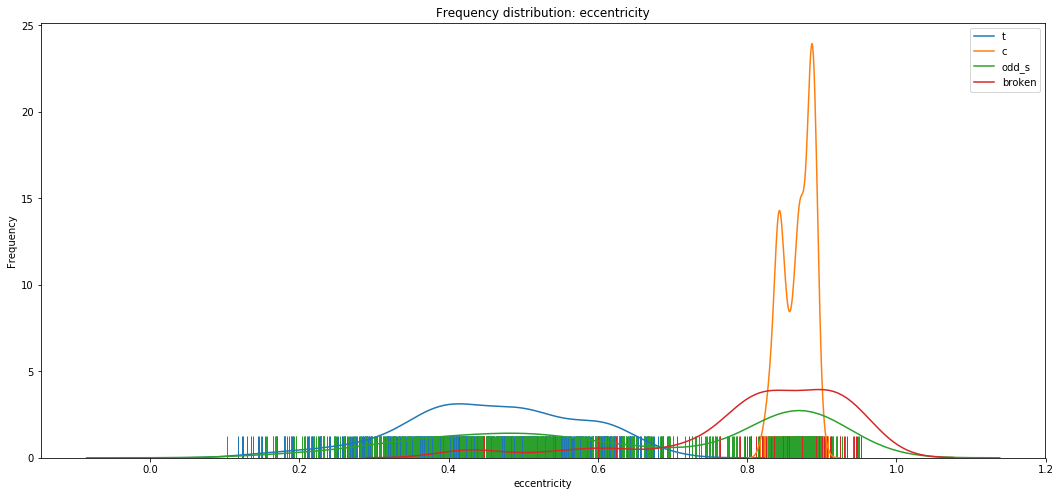

In [23]:
"""FINDING CORRECT THRESHOLDS FOR SHAPE DISCRIMINATION"""

"""STILL RESULTS OF FILTERING"""
Inertias_list = []
for i in range(num_shape_cats):
    x = [h.inertia_tensor[0, 0] + h.inertia_tensor[1,1] for h in T_thresh_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

    
Inertias_list = []
for i in range(num_shape_cats):
    x = [h[1].inertia_tensor[0, 0] + h[1].inertia_tensor[1,1] for h in Filtrates_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
    
    
    
    
propnames = ["convex_area", "minor_axis_length", "major_axis_length", "solidity", "eccentricity"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h, propnames[k]) for h in T_thresh_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h[1], propnames[k]) for h in Filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        
        


# don't use: extent, perimeter, minor axis lengths, solidity, eccetricity
# inertia: 300 - 360 br/bl, 350 - 415 tr/tl, 417/412 - bm
# mal: 56 - 63 br/bl, 63 - 70 tr/tl, 68 bm
# ecc: .63 - .78 br/bl, .76 - .83 tr/tl, .76 bm

# if solidity <= .76 and inertia > 400 => bm
# elif inertia >=355 and mal >= 63 => tl/tr
# elif inertia <= 355 and mal <= 63 => bl/br
# else unclassifiable

In [ ]:
"""DO A PCA ON EACH OF THE SETS AND PLOT SEPARATION. DISPLAY PRINCIPAL AXIS LOADINGS"""